In [1]:
import jax
import jax.numpy as np # try to do everything with jax...
import numpy  as onp
import pandas as pd
import pymc3  as pm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as patheffects
import cmocean as cmo
import glob

from tqdm  import tqdm, trange
from jax import grad, jit, vmap, jacfwd, jacrev, lax
from jax.lax import cond
from jax.config import config; config.update("jax_enable_x64", True)
from jax.experimental import ode
from functools import partial
from scipy.optimize import minimize
from natsort import natsorted
import theano
import theano.tensor as tt
import seaborn as sns
import arviz as az
import cmocean
mpl.style.use(['seaborn-poster', 'seaborn-muted'])

#betanalphas' colormap
colors = ["#DCBCBC","#C79999","#B97C7C","#A25050","#8F2727", "#7C0000","#DCBCBC20", "#8F272720","#00000060"]
color  = {i[0]:i[1] for i in zip(['light','light_highlight','mid','mid_highlight','dark','dark_highlight','light_trans','dark_trans','superfine'],colors)}
fancycolors = [mpl.colors.to_hex(c) for c in [[0.6, 0.6, 0.6],[0.7, 0.3, 1],[0.3, 0.7, 1],[0.2, 0.9, 0.9],
                                              [0.3, 1, 0.7],[0.7, 1, 0.3],[0.9, 0.9, 0.2],[1, 0.7, 0.3],[1, 0.3, 0.7],
                                              [0.9, 0.2, 0.9],[1.0, 1.0, 1.0]]]
threecolors = [mpl.colors.to_hex(c) for c in [[0.1, 0.15, 0.4],[1, 0.2, 0.25],[1.0, 0.775, 0.375]]]
fourcolors = [mpl.colors.to_hex(c) for c in [[0.9, 0.6, 0.3],[0.9, 0.4, 0.45],[0.5, 0.65, 0.75],[0.42, 0.42, 0.75]]]

def addtxt(ax, x, y, txt, fs=8, lw=3, clr='k', bclr='w', rot=0):
    """Add text to figure axis"""
    return ax.text(x, y, txt, color=clr, ha='left', transform=ax.transAxes, rotation=rot, weight='bold',
                   path_effects=[patheffects.withStroke(linewidth=lw, foreground=bclr)], fontsize=fs)
def hessian(f):
    """Returns a function which computes the Hessian of a function f
           if f(x) gives the values of the function at x, and J = hessian(f)
           J(x) gives the Hessian at x"""
    return jit(jacfwd(jacrev(f)))
def savefig(fig, name, **kargs):
    fig.savefig(f'./fig_para/{name}.png', bbox_inches='tight', **kargs)
    fig.savefig(f'./fig_para/{name}.pdf', bbox_inches='tight', **kargs)
def saveaxes(axes, name, **kargs):
    fig = axes.ravel()[0].figure
    savefig(fig, name, **kargs)

Consider the upper-convected Maxwell (UCM) and Giesekus Models
\begin{align}
\frac{\text{d}{\sigma}}{\text{d}{t}} &= 
{\kappa}\cdot{\sigma}^\textsf{T} + 
{\sigma}\cdot{\kappa}^\textsf{T} +
\frac{1}{\text{De}} \left({\kappa} + {\kappa}^\textsf{T}\right) -
\frac{1}{\text{De}} {\sigma}&(\text{UCM})\\
\frac{\text{d}{\sigma}}{\text{d}{t}} &= \left.\frac{\text{d}{\sigma}}{\text{d}t}\right\rvert^{(UCM)} -
\alpha{\sigma}\cdot{\sigma} &(\text{Giesekus})\\
\frac{\text{d}{\sigma}}{\text{d}{t}} &= \left.\frac{\text{d}{\sigma}}{\text{d}t}\right\rvert^{(UCM)} -
\frac{\alpha}{3}\left[\left({\kappa} + {\kappa}^{\textsf{T}}\right)\colon{\sigma}\right]\left(\text{De}\,{\sigma} + \textsf{I}\right) &(\text{Larson})
\end{align}
We will consider simple-shear flow, with ${\kappa}_{xy} = 20$ and ${\kappa}_{xx} = {\kappa}_{yx} = {\kappa}_{yy} = 0$ with $\text{De} = 0.01$, $\alpha=0.3$, and $a=0.1$.

In [2]:
@jit
def ucm(σ, t, κ, p):
    De = p[0]
    dσ = np.einsum('ik,jk->ij',κ,σ) + np.einsum('ik,jk->ij',σ,κ) + 1/De*(κ + np.transpose(κ)) - σ/De
    return dσ

@jit
def giesekus(σ, t, κ, p):
    De,α = p[0],p[1]
    dσ = ucm(σ, t, κ, p[0:1]) - α*np.einsum('ik,kj->ij', σ, σ)
    return dσ

@jit
def larson(σ, t, κ, p):
    De,α = p[0],p[1]
    dσ = ucm(σ, t, κ, p[0:1]) - α/3*(np.einsum('ij,ji', κ, σ) + np.einsum('ij,ij', κ, σ))*(De*σ + np.eye(2))
    return dσ

ducm      = jit(vmap(ucm,      in_axes=(0,0,None,None)))
dgiesekus = jit(vmap(giesekus, in_axes=(0,0,None,None)))
dlarson   = jit(vmap(larson,   in_axes=(0,0,None,None)))

In [3]:
@partial(jit, static_argnums=(0,))
def runge_kutta_step(func, y0, f0, t0, dt):
    # Dopri5 Butcher tableaux
    alpha = np.array([1 / 5, 3 / 10, 4 / 5, 8 / 9, 1., 1., 0])   
    beta = np.array([
      [1 / 5, 0, 0, 0, 0, 0, 0],
      [3 / 40, 9 / 40, 0, 0, 0, 0, 0],
      [44 / 45, -56 / 15, 32 / 9, 0, 0, 0, 0],
      [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0, 0, 0],
      [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656, 0, 0],
      [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0]
    ])
    c_sol = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0])
    
    def body_fun(k, i):
        ti = t0 + dt * alpha[i-1]
        yi = y0 + dt * np.einsum('i,i...->...', beta[i-1, :], k)
        ft = func(yi, ti)
        return k.at[i, :].set(ft), i

    k   = np.zeros((7,)+f0.shape, f0.dtype).at[0, :].set(f0)
    k,_ = lax.scan(body_fun, k, np.arange(1, 7))
    y1 = dt * np.einsum('i,i...->...',c_sol, k) + y0
    f1 = k[-1]
    return y1, f1

@partial(jit, static_argnums=(0,))
def integrate(func, y0, micro_times, macro_times, *args):    
    func_ = lambda y, t : func(y, t, *args)
    dt    = (micro_times[1]-micro_times[0])
    def micro_fun(carry, target_time):
        y, f, t        = carry
        next_y, next_f = runge_kutta_step(func_, y, f, t, dt)
        return [next_y, next_f, t + dt], y
    def macro_fun(carry, target_time):
        carry, _  = jax.lax.scan(micro_fun, carry, micro_times)
        y, *_     = carry
        return carry, y
    
    f0         = func_(y0, macro_times[0])
    init_carry = [y0, f0, macro_times[0]]
    _, ys   = jax.lax.scan(macro_fun, init_carry, macro_times[1:])
    return np.concatenate((y0[None], ys))

In [4]:
@partial(jit, static_argnums=(0,1))
def constitutive_solution(f, df, t, σ0, κ, p):
    """Use jax's default variable time-step integrator -> can't be vmapped !"""
    fargs = (κ, p)
    σ     = ode.odeint(f, σ0, t, *fargs)
    dσ    = df(σ, t, *fargs)
    return σ,dσ

@partial(jit, static_argnums=(0,1))
def constitutive_solution_fixed(f, df, t, τ, σ0, κ, p):
    """Use fixed time step integrator that can be vmapped...I thought """
    fargs = (κ, p)
    σ     = integrate(f, σ0, τ, t, *fargs)
    dσ    = df(σ, t, *fargs)
    return σ,dσ
#ensemble_solution = jit(vmap(constitutive_solution, in_axes=(None, None, None, None, None, None, 0)))

def ensemble_solution(f, df, t, σ0, κ, p):
    nts,num = len(t),len(p)
    σs  = np.zeros((num,nts,)+σ0.shape)
    dσs = np.zeros_like(σs)
    for i in trange(num):
        σ,dσ = constitutive_solution(f, df, t, σ0, κ, p[i])
        σs = jax.ops.index_update(σs, jax.ops.index[i,...], σ)
        dσs= jax.ops.index_update(dσs,jax.ops.index[i,...], dσ)
    return σs, dσs

In [5]:
params       = {'σ0':np.zeros((2,2)), 'κ':np.array([[0.0, 20.0], [0.0, 0.0]]), 'De':0.01, 'α':0.3, 'a':0.3}
params['κT'] = np.transpose(params['κ'])
params['D']  = params['κ'] + params['κT']
t            = np.linspace(0.0, 0.1, num=40)
nmicro       = 2**7        
τ            = np.arange(1,nmicro+1)*(t[1]-t[0])/nmicro
print(τ[1]-τ[0], t[1]-t[0])

σucm,dσucm  = constitutive_solution(ucm, ducm, t, params['σ0'], params['κ'], [params['De']])
σgie,dσgie  = constitutive_solution(giesekus, dgiesekus, t, params['σ0'], params['κ'], [params['De'], params['α']]) 
σlar,dσlar  = constitutive_solution(larson, dlarson, t, params['σ0'], params['κ'], [params['De'], params['a']])

2.0032051282051282e-05 0.002564102564102564


In [6]:
# Verifity that our solution matches the odeint solution
def check_solution():
    σucm0,dσucm0  = constitutive_solution_fixed(ucm, ducm, t, τ, params['σ0'], params['κ'], [params['De']])
    σgie0,dσgie0  = constitutive_solution_fixed(giesekus, dgiesekus, t, τ, params['σ0'], params['κ'], [params['De'], params['α']]) 
    σlar0,dσlar0  = constitutive_solution_fixed(larson, dlarson, t, τ, params['σ0'], params['κ'], [params['De'], params['a']])
    print(np.max(np.abs(σucm-σucm0)), np.max(np.abs(dσucm-dσucm0)))
    print(np.max(np.abs(σgie-σgie0)), np.max(np.abs(dσgie-dσgie0)))
    print(np.max(np.abs(σlar-σlar0)), np.max(np.abs(dσlar-dσlar0)))
check_solution()

1.0353520352168744e-07 1.0353520337957889e-05
8.472095203160279e-08 8.772862656769576e-06
9.302206649408618e-08 9.487167289989884e-06


We add a random Gaussian noise to each component of $\dot{\widetilde{\sigma}}$, whose amplitude is $40\%$ of the standard deviation (with a minimum value of $0.5$). 

In [7]:
def noisify(key, y, rel_amplitude, abs_amplitude):
    sig       = np.std(y, axis=0)
    amplitude = np.maximum(sig*rel_amplitude, abs_amplitude*np.ones_like(sig))
    print(amplitude[0,0], amplitude[0,1], amplitude[1,1])
    print()
    return y + amplitude*jax.random.normal(key, y.shape)

key = jax.random.PRNGKey(12345711)
dσucm_train = noisify(key, dσucm, 0.2, 0.5)
key,subkey  = jax.random.split(key)
dσgie_train = noisify(key, dσgie, 0.2, 0.5)
key,subkey  = jax.random.split(key)
dσlar_train = noisify(key, dσlar, 0.2, 0.5)

19.578787725209637 89.52934989692957 0.5

17.09612200857776 89.57143910962235 2.609095317439282

17.47696272425479 89.42857190682979 1.9418847471394203



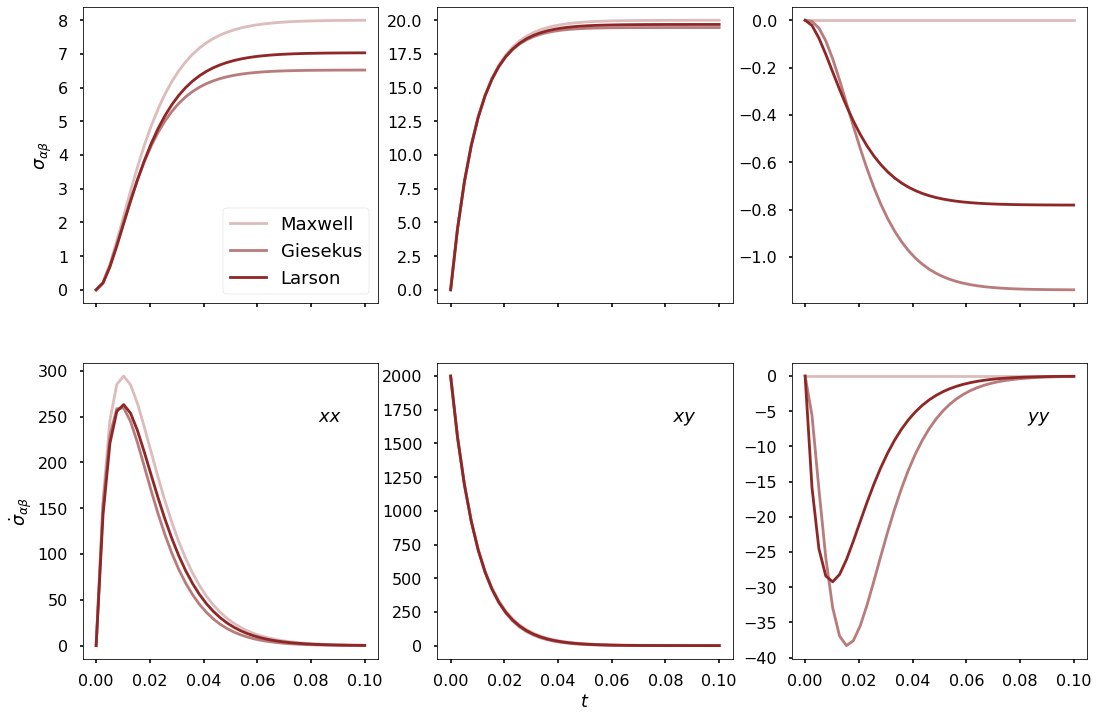

In [8]:
fig, axes = plt.subplots(figsize=(18,12),ncols=3, nrows=2, sharex=True)
ijs = [[0,0], [0,1], [1,1]]
clrs= [color['light'], color['mid'], color['dark']]
lbls= [r'$xx$', r'$xy$', r'$yy$']
tags= ['Maxwell', 'Giesekus', 'Larson']
up,down = axes[0], axes[1]
for n,ax in enumerate(down):
    i,j = ijs[n]
    addtxt(ax, 0.8, 0.8, lbls[n], fs=18)
    for m,data in enumerate([dσucm, dσgie, dσlar]):
        ax.plot(t, data[:,i,j], color=clrs[m], label=tags[m])
for n,ax in enumerate(up):
    i,j = ijs[n]
    for m,data in enumerate([σucm, σgie, σlar]):
        ax.plot(t, data[:,i,j], color=clrs[m], label=tags[m])
axes[0,0].legend(fontsize=18)
axes[0,0].set_ylabel(r'$\sigma_{\alpha\beta}$')
axes[1,0].set_ylabel(r'$\dot{\sigma}_{\alpha\beta}$')
axes[1,1].set_xlabel(r'${t}$')
savefig(fig, 'cons_eq')
plt.show()

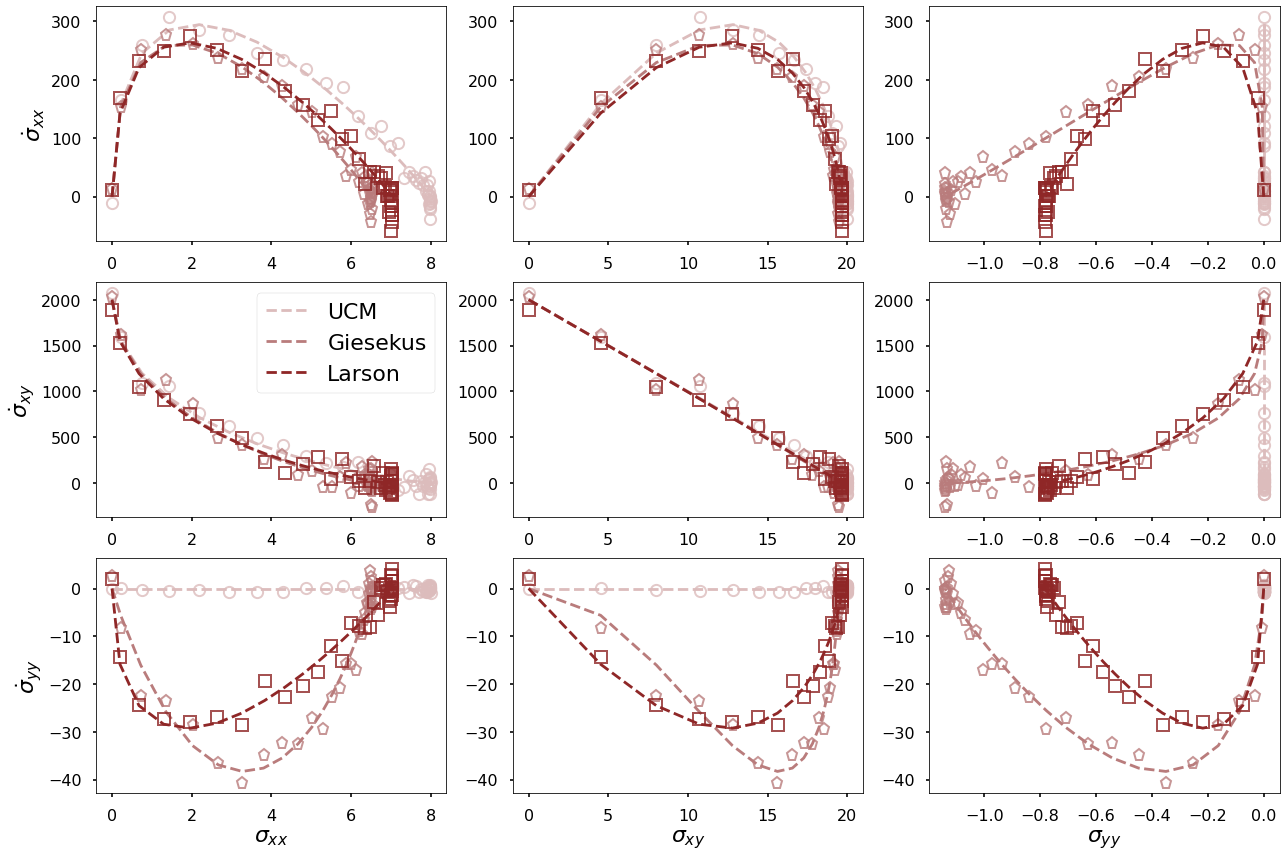

In [9]:
def plot_model(axes, σ,dσ_gold,dσ_obs,color,label,marker):
    ids = [[0,0], [0,1], [1,1]]
    for i,row in enumerate(axes):
        α,β = ids[i]
        for j,ax in enumerate(row):
            μ,ν = ids[j]
            ax.plot(σ[:,μ,ν], dσ_gold[:,α,β], color=color, label=label, ls='--')
            ax.plot(σ[:,μ,ν], dσ_obs[:,α,β],  color=color, marker=marker, ls='None', mfc='None', mew=2, alpha=0.8)

fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)
plot_model(axes, σucm, dσucm, dσucm_train, color=color['light'], label='UCM', marker='o')
plot_model(axes, σgie, dσgie, dσgie_train, color=color['mid'], label='Giesekus', marker='p')
plot_model(axes, σlar, dσlar, dσlar_train, color=color['dark'], label='Larson', marker='s')

axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\sigma_{lbls[i]}$", fontsize=22)
savefig(fig, 'cons_eq_noisy')

fig.tight_layout()

In [10]:
def check_tensordot(σ):
    κ = np.array([[1.0, 2.0], [10.0, -5.0]])
    # \sigma . \kappa^T
    sk_1 = np.einsum('...ik,jk->...ij',σ,κ)
    sk_2 = np.tensordot(σ,κ, axes=([2],[1]))
    print('σ.κT ? ', np.allclose(sk_1,sk_2))    

    # \kappa . \sigma^T
    ks_1 = np.einsum('ik,...jk->...ij',κ,σ) 
    ks_2 = np.transpose(sk_2, (0,2,1))
    print('κ.σT ? ',np.allclose(ks_1,ks_2))
    
    # \sigma . \sigma -> FAIL
    #    ss_0 = np.einsum('...ik,...kj->...ij',σ,σ)
    #    ss_1 = np.einsum('...ik,...jk->...ij',σ,σ)
    #ss_2 = np.tensordot(σ,σ, axes=([2],[2]))
    #print(σ.shape, ss_1.shape, ss_2.shape)
    #print('σ.σ  ? ', np.allclose(ss_1, ss_2))
check_tensordot(σlar)

σ.κT ?  True
κ.σT ?  True


In [11]:
κ      = theano.shared(onp.array(params['κ'])) # shared variables wont accept jax numpy arrays
κT     = theano.shared(onp.array(params['κT']))
D      = theano.shared(onp.array(params['D']))
dscale = np.max(dσucm)

def Maxwell(De, σ, σκ):
    return σκ + tt.transpose(σκ, (0,2,1)) + D/De - σ/De
def Maxwell0(De, σ):
    σκ = np.einsum('...ik,jk->...ij', σ, params['κ'])
    return σκ + np.transpose(σκ, (0,2,1)) + params['D']/De - σ/De
def dot(A,B):
    return np.einsum('...ik,...kj->...ij', A, B) # couldn't write in terms of tensordot...
def ddot(A,B):
    return np.einsum('...ij,...ji->...', A, B)

with pm.Model() as model_ucm:
    # model data - reset if using different fitting data
    data_σdot = pm.Data('data_σdot', dσucm_train/dscale)    
    σ         = pm.Data('σ', σucm)
    
    σκ        = tt.tensordot(σ,κ,axes=([2],[1]))
    
    De   = pm.distributions.continuous.HalfNormal('De', sigma=0.5)
    logϵ = pm.distributions.continuous.Uniform('logϵ', lower=-10, upper=6,shape=3)  # xx,xy,yy noise
    ϵ    = pm.Deterministic('ϵ', tt.exp(logϵ))

    σdot = Maxwell(De, σ, σκ)/dscale
    
    σdot_xx = pm.distributions.continuous.Normal('σdot_xx', mu = σdot[:,0,0], sigma = ϵ[0], observed=data_σdot[:,0,0])
    σdot_xy = pm.distributions.continuous.Normal('σdot_xy', mu = σdot[:,0,1], sigma = ϵ[1], observed=data_σdot[:,0,1])
    σdot_yy = pm.distributions.continuous.Normal('σdot_yy', mu = σdot[:,1,1], sigma = ϵ[2], observed=data_σdot[:,1,1])

def logp_normal(ydata,ymodel,yerr):
    """(minus) log posterior of normal distribution"""
    dy = (ydata - ymodel)/yerr
    return 0.5*np.sum(dy**2) + 0.5*len(ydata)*np.log(2*onp.pi*yerr**2)

def logp_ucm(p, σdot, σ):
    """(minus) log posterior for ucm model parameters, use Jeffrey's prior for noise amplitude"""
    De,ϵxx,ϵxy,ϵyy = np.exp(p)       # parameters must be positive, work with logarithms for simplicity
    σdot_model     = Maxwell0(De, σ)
    npoints        = len(σdot)
    like_xx        = logp_normal(σdot[:,0,0]/dscale, σdot_model[:,0,0]/dscale, ϵxx)
    like_xy        = logp_normal(σdot[:,0,1]/dscale, σdot_model[:,0,1]/dscale, ϵxy)
    like_yy        = logp_normal(σdot[:,1,1]/dscale, σdot_model[:,1,1]/dscale, ϵyy)
    return (like_xx + like_xy + like_yy + 0.5*(De/0.5)**2 + np.log(ϵxx) + np.log(ϵxy) + np.log(ϵyy))/npoints # (minus) log-posterior
dlogp_ucm = jit(grad(logp_ucm))
hess_ucm  = hessian(logp_ucm)

def logp_ucm0(p, σdot, σ):
    """(minus) log posterior for ucm model"""
    return logp_ucm(np.log(p), σdot, σ)
dlogp_ucm0= jit(grad(logp_ucm0))
hess_ucm0 = hessian(logp_ucm0)

def max_aposteriori(logp, dlogp, init, dσ_train, σ_train):
    """compute MAP estimate by minimizing the negative of the log-posterior"""
    opt = [{'x':init}]
    opt.append(minimize(logp, opt[-1]['x'], args=(dσ_train, σ_train), method='Nelder-Mead'))
    opt.append(minimize(logp, opt[-1]['x'], args=(dσ_train, σ_train), method='BFGS', jac=dlogp))
    x = np.exp(opt[-1]['x'])
    print(opt[-1]['message'])
    print(x[:-3])
    print(x[-3:]*dscale) # noise is scaled by dscale
    return opt[-1]

def get_laplace(xs, xopt, hess, σdot, σ, index, scale=1):
    avg = xopt[index]*scale
    var = np.diag(np.linalg.inv(hess(xopt, σdot, σ)))[index]/len(σ)*scale**2
    return xs, 1.0/(np.sqrt(2*onp.pi*var)) * np.exp(-0.5*(xs - avg)**2/var)

# We can work with either x or y = log(x), but minimization is easier with y (in case of parameters that need to be positive)
# To get error estimate / laplace approximation we need to compute hessian with respect to x (not y), here we check the conversion between the two
def check_hess(y0, σdot, σ, dy, d2y, d2x):
    x0 = np.exp(y0)
    hy = np.einsum('i,j->ij',1/x0,1/x0)*d2y(y0, σdot, σ) - np.diag(1/x0**2*dy(y0, σdot, σ))
    hx = d2x(x0, σdot, σ)
    print(np.linalg.norm(hx-hy), np.allclose(hx, hy))    

In [12]:
with pm.Model()as model_gie:
    # model data - reset if using different fitting data
    data_σdot = pm.Data('data_σdot', dσgie_train/dscale)
    σ         = pm.Data('σ',  σgie)
    σ2        = pm.Data('σ2',dot(σgie, σgie))
    
    σκ        = tt.tensordot(σ,κ,axes=([2],[1]))

    De   = pm.distributions.continuous.HalfNormal('De', sigma=0.5)
    α    = pm.distributions.continuous.Uniform('α', lower=0, upper=0.5)
    logϵ = pm.distributions.continuous.Uniform('logϵ', lower=-10, upper=6,shape=3)  # xx,xy,yy noise
    ϵ    = pm.Deterministic('ϵ', tt.exp(logϵ))


    σdot = (Maxwell(De, σ, σκ) - α*σ2)/dscale
    
    σdot_xx = pm.distributions.continuous.Normal('σdot_xx', mu = σdot[:,0,0], sigma = ϵ[0], observed=data_σdot[:,0,0])
    σdot_xy = pm.distributions.continuous.Normal('σdot_xy', mu = σdot[:,0,1], sigma = ϵ[1], observed=data_σdot[:,0,1])
    σdot_yy = pm.distributions.continuous.Normal('σdot_yy', mu = σdot[:,1,1], sigma = ϵ[2], observed=data_σdot[:,1,1])

def logp_gie(p, σdot, σ):
    """(minus) log posterior for giesekus model parameters, use Jeffrey's prior for noise amplitude"""
    De,α,ϵxx,ϵxy,ϵyy = np.exp(p)       # parameters must be positive, work with logarithms for simplicity
    σdot_model       = Maxwell0(De, σ) - α*dot(σ,σ)
    npoints          = len(σdot)
    like_xx          = logp_normal(σdot[:,0,0]/dscale, σdot_model[:,0,0]/dscale, ϵxx)
    like_xy          = logp_normal(σdot[:,0,1]/dscale, σdot_model[:,0,1]/dscale, ϵxy)
    like_yy          = logp_normal(σdot[:,1,1]/dscale, σdot_model[:,1,1]/dscale, ϵyy)
    return (like_xx + like_xy + like_yy + 0.5*(De/0.5)**2 + np.log(ϵxx) + np.log(ϵxy) + np.log(ϵyy))/npoints # (minus) log-posterior
dlogp_gie = jit(grad(logp_gie))
hess_gie  = hessian(logp_gie)

def logp_gie0(p, σdot, σ):
    """(minus) log posterior for ucm model"""
    return logp_gie(np.log(p), σdot, σ)
dlogp_gie0= jit(grad(logp_gie0))
hess_gie0 = hessian(logp_gie0)

In [13]:
with pm.Model()as model_lar:
    # model data - reset if using different fitting data
    data_σdot = pm.Data('data_σdot', dσlar_train/dscale)
    σ         = pm.Data('σ', σlar)
    Dσ        = pm.Data('Dσ', ddot(params['D'], σlar))
    
    σκ        = tt.tensordot(σ,κ,axes=([2],[1]))
    
    De   = pm.distributions.continuous.HalfNormal('De', sigma=0.5)
    α    = pm.distributions.continuous.Uniform('α', lower=0, upper=0.5)
    logϵ = pm.distributions.continuous.Uniform('logϵ', lower=-10, upper=6,shape=3)  # xx,xy,yy noise
    ϵ    = pm.Deterministic('ϵ', tt.exp(logϵ))

    σdot = (Maxwell(De, σ, σκ) - α/3.0*Dσ[...,None,None]*(De*σ + tt.eye(2)[None,...]))/dscale
    
    σdot_xx = pm.distributions.continuous.Normal('σdot_xx', mu = σdot[:,0,0], sigma = ϵ[0], observed=data_σdot[:,0,0])
    σdot_xy = pm.distributions.continuous.Normal('σdot_xy', mu = σdot[:,0,1], sigma = ϵ[1], observed=data_σdot[:,0,1])
    σdot_yy = pm.distributions.continuous.Normal('σdot_yy', mu = σdot[:,1,1], sigma = ϵ[2], observed=data_σdot[:,1,1])

def logp_lar(p, σdot, σ):
    """(minus) log posterior for giesekus model parameters, use Jeffrey's prior for noise amplitude"""
    De,α,ϵxx,ϵxy,ϵyy = np.exp(p)       # parameters must be positive, work with logarithms for simplicity
    Dσ               = ddot(params['D'], σ)
    σdot_model       = Maxwell0(De, σ) - α/3*Dσ[...,None,None]*(De*σ + np.eye(2)[None,...])
    npoints          = len(σdot)
    like_xx          = logp_normal(σdot[:,0,0]/dscale, σdot_model[:,0,0]/dscale, ϵxx)
    like_xy          = logp_normal(σdot[:,0,1]/dscale, σdot_model[:,0,1]/dscale, ϵxy)
    like_yy          = logp_normal(σdot[:,1,1]/dscale, σdot_model[:,1,1]/dscale, ϵyy)
    return (like_xx + like_xy + like_yy + 0.5*(De/0.5)**2 + np.log(ϵxx) + np.log(ϵxy) + np.log(ϵyy))/npoints # (minus) log-posterior
dlogp_lar = jit(grad(logp_lar))
hess_lar  = hessian(logp_lar)

def logp_lar0(p, σdot, σ):
    """(minus) log posterior for ucm model"""
    return logp_lar(np.log(p), σdot, σ)
dlogp_lar0= jit(grad(logp_lar0))
hess_lar0 = hessian(logp_lar0)

# UCM

In [14]:
with model_ucm:
    pm.set_data({'σ':σucm, 'data_σdot':dσucm_train/dscale})
    sim_ucm = pm.sample(20000, tune=10000, cores=6, random_seed = 123511) # draw 4000 posterior samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [logϵ, De]
INFO:pymc3:NUTS: [logϵ, De]


Sampling 6 chains for 10_000 tune and 20_000 draw iterations (60_000 + 120_000 draws total) took 46 seconds.
INFO:pymc3:Sampling 6 chains for 10_000 tune and 20_000 draw iterations (60_000 + 120_000 draws total) took 46 seconds.


In [15]:
opt_ucm = max_aposteriori(logp_ucm, dlogp_ucm, np.array([-3.0, 0.0, 0.0, 0.0]), dσucm_train, σucm)
θucm    = np.exp(opt_ucm['x'])

Optimization terminated successfully.
[0.00998857]
[14.70270151 69.74114113  0.51952544]


<Figure size 864x864 with 0 Axes>

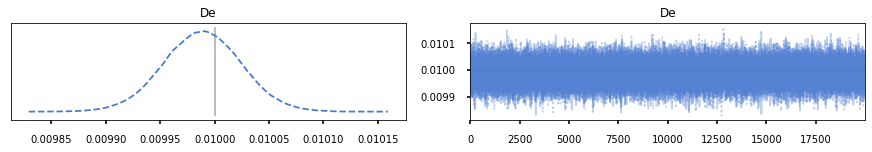

In [16]:
plt.figure(figsize=(12,12))
with model_ucm:
    axes = pm.traceplot(sim_ucm, var_names=['De'], lines=[['De', {}, 0.01]], combined=True)
saveaxes(axes, 'ucm_trace')

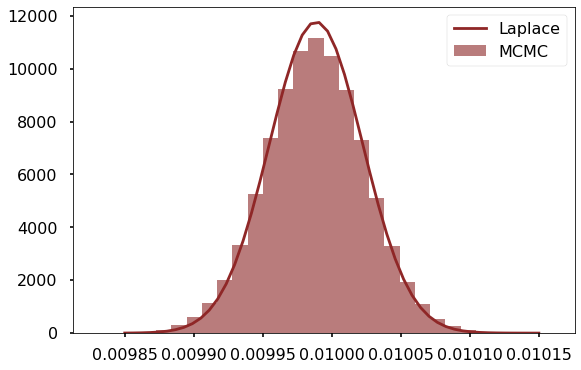

In [17]:
fig, ax = plt.subplots(figsize=(9,6))
ax.hist(sim_ucm['De'], density=True, bins=30, color=color['mid'], label='MCMC')
avg,std = get_laplace(np.linspace(9.85e-3, 1.015e-2), θucm, hess_ucm0, dσucm_train, σucm, 0, 1.0)
ax.plot(avg, std,  label='Laplace', color=color['dark'])
ax.legend()
plt.show()

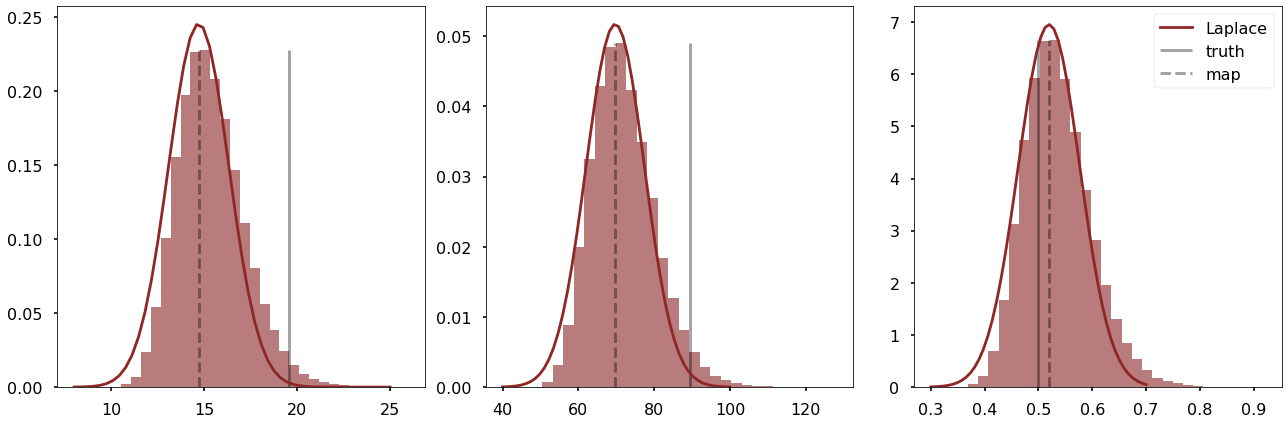

In [18]:
fig, axes = plt.subplots(figsize=(18,6),ncols=3)
egold = [19.578787725209633, 89.52934989692963, 0.5]
lims  = [[8,25], [40,100], [0.3,0.7]]
for i,ax in enumerate(axes):
    h = ax.hist(sim_ucm['ϵ'][:,i]*dscale, density=True, bins=30, color=color['mid'])
    xm= np.exp(opt_ucm['x'][1+i])*dscale
    ax.vlines(egold[i], 0.0, np.max(h[0]), color=color['superfine'], label='truth') # theoretical value
    ax.vlines(xm, 0.0, np.max(h[0]), color=color['superfine'], label='map', linestyles='--')    # map value
    avg, std = get_laplace(np.linspace(lims[i][0], lims[i][1]), θucm, hess_ucm0, dσucm_train, σucm, i+1, dscale)
    ax.plot(avg, std,  label='Laplace', color=color['dark'])
axes[-1].legend()
fig.tight_layout()

In [19]:
σucm_sim, dσucm_sim = ensemble_solution(ucm, ducm, t, params['σ0'], params['κ'], sim_ucm['De'][::300,None])

100%|██████████| 400/400 [00:01<00:00, 321.54it/s]


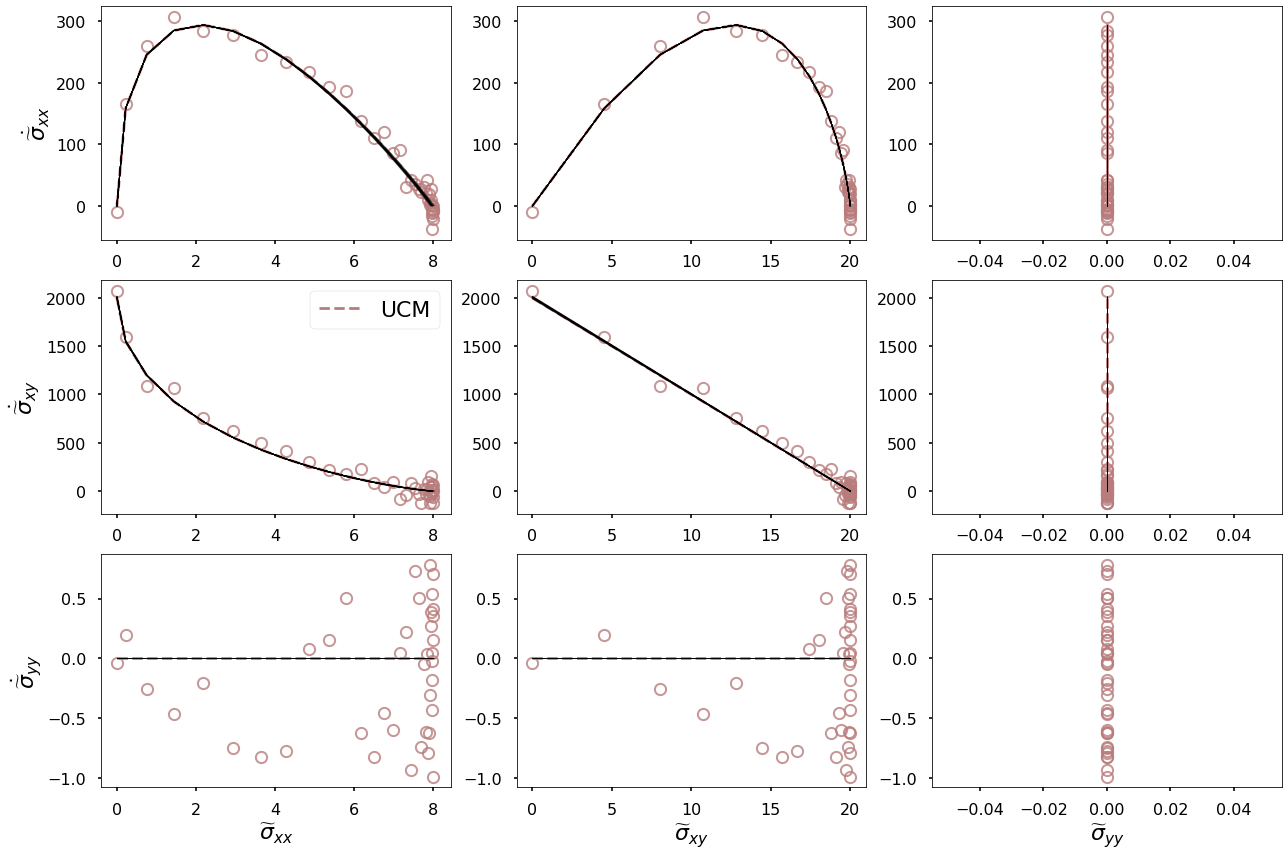

In [20]:
def plot_posterior(axes, σpost,dσpost,skip, **kargs):
    ids = [[0,0], [0,1], [1,1]]
    for i,row in enumerate(axes):
        α,β = ids[i]
        for j,ax in enumerate(row):
            μ,ν = ids[j]
            for k in range(len(σpost[::skip])):
                ax.plot(σpost[k,:,μ,ν], dσpost[k,:,α,β], **kargs)

fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)
plot_model(axes, σucm, dσucm, dσucm_train, color=color['mid'], label='UCM', marker='o')
plot_posterior(axes, σucm_sim, dσucm_sim, 10, **{'alpha':0.2, 'lw':1, 'color':color['superfine']})

axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\widetilde\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\widetilde\sigma_{lbls[i]}$", fontsize=22)

fig.tight_layout()
savefig(fig, 'ucm_mcmc')

# Giesekus

In [21]:
with model_gie:
    pm.set_data({'σ':σgie, 'σ2':dot(σgie, σgie), 'data_σdot':dσgie_train/dscale})
    sim_gie = pm.sample(20000, tune=16000, cores=6, random_seed = 123511) # draw 4000 posterior samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [logϵ, α, De]
INFO:pymc3:NUTS: [logϵ, α, De]


Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 56 seconds.
INFO:pymc3:Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 56 seconds.


In [22]:
opt_gie = max_aposteriori(logp_gie, dlogp_gie, np.array([-3.0, 0.0, 0.0, 0.0, 0.0]), dσgie_train, σgie)
θgie   = np.exp(opt_gie['x'])

Optimization terminated successfully.
[0.01004185 0.2998838 ]
[ 17.12005866 110.87808299   2.58202871]


<Figure size 864x864 with 0 Axes>

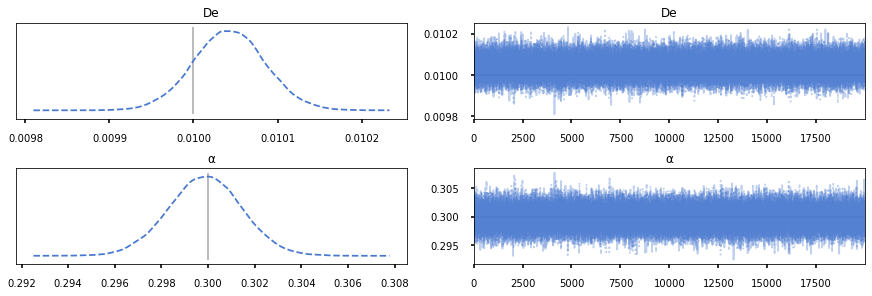

In [23]:
plt.figure(figsize=(12,12))
with model_gie:
    axes = pm.traceplot(sim_gie, var_names=['De', 'α'], combined=True, lines=[['De', {}, 0.01], 
                                                                       ['α', {}, 0.3]])
plt.show()
saveaxes(axes, 'gie_trace')

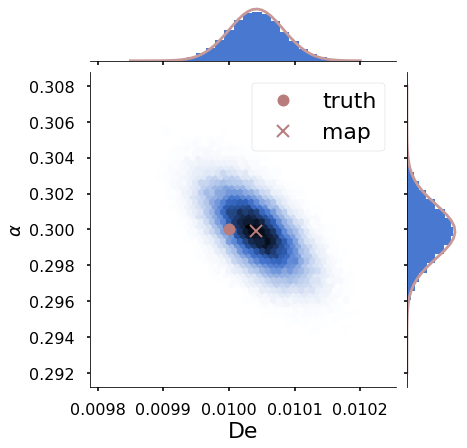

In [24]:
fig = sns.jointplot(x=sim_gie['De'], y=sim_gie['α'], kind="hex").fig
ax,bx,cx  = fig.axes
bx.patches.clear()
cx.patches.clear()

ax.plot([0.01], [0.3], marker='o', markersize=12, color=color['mid'],ls='None', label='truth')
ax.plot(θgie[0], θgie[1], marker='x', markersize=12, color=color['mid'], ls='None', mew=2, label='map')

bx.hist(sim_gie['De'], density=True, bins=30)
avg,std = get_laplace(np.linspace(9.85e-3, 1.02e-2), θgie, hess_gie0, dσgie_train, σgie, 0, 1.0)
bx.plot(avg, std, color=color['light_highlight'], ls='-')

cx.hist(sim_gie['α'], density=True, bins=30, orientation='horizontal')
avg,std = get_laplace(np.linspace(.292, .308), θgie, hess_gie0, dσgie_train, σgie, 1, 1.0)
cx.plot(std, avg, color=color['light_highlight'], ls='-')
cx.set_xlim(0,np.max(std)*1.1)

ax.set_xlabel(r'De',fontsize=22)
ax.set_ylabel(r'$\alpha$', fontsize=18)
ax.legend(fontsize=22)
savefig(fig, 'gie_joint')
plt.show()

In [25]:
σgie_sim, dσgie_sim = ensemble_solution(giesekus, dgiesekus, t, params['σ0'], params['κ'],
                                                   np.transpose(np.stack([sim_gie['De'][::300], sim_gie['α'][::300]])))

100%|██████████| 400/400 [00:01<00:00, 254.92it/s]


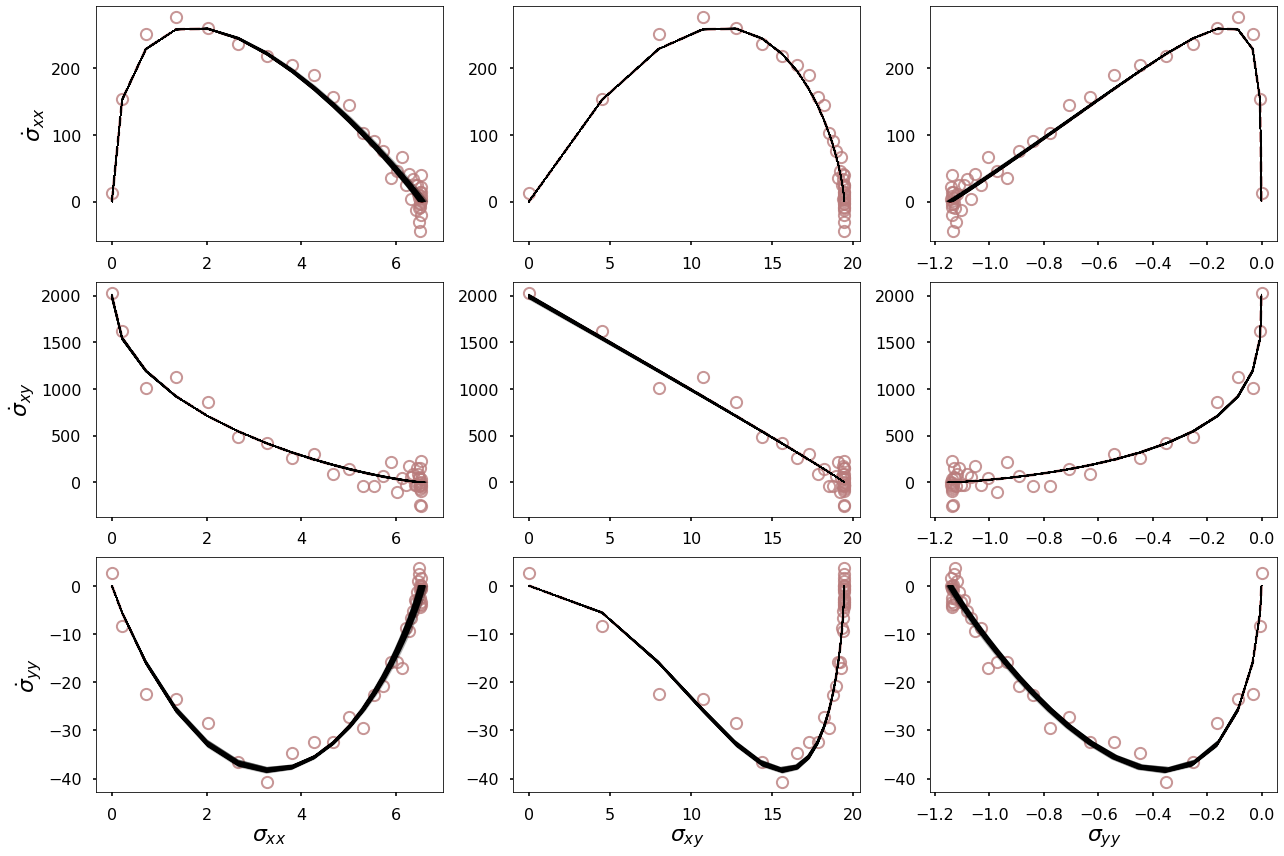

In [28]:
fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)

plot_model(axes, σgie, dσgie, dσgie_train, color=color['mid'], label='Giesekus', marker='o')
plot_posterior(axes, σgie_sim, dσgie_sim, 1, **{'alpha':0.2, 'lw':1, 'color':color['superfine']})

#axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\sigma_{lbls[i]}$", fontsize=22)
fig.tight_layout()
savefig(fig, 'gie_mcmc')

# Larson

In [29]:
with model_lar:
    pm.set_data({'σ':σlar, 'Dσ':ddot(params['D'], σlar), 'data_σdot':dσlar_train/dscale})
    sim_lar = pm.sample(20000, tune=16000, cores=6, random_seed = 123511) # draw 4000 posterior samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [logϵ, α, De]
INFO:pymc3:NUTS: [logϵ, α, De]


Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 60 seconds.
INFO:pymc3:Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 864x864 with 0 Axes>

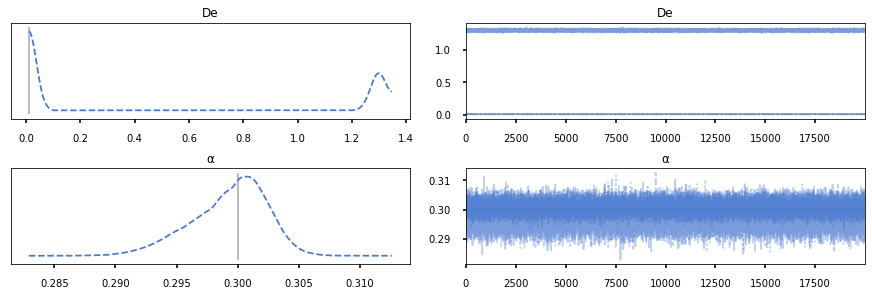

In [30]:
plt.figure(figsize=(12,12))
with model_lar:
    axes = pm.traceplot(sim_lar, var_names=['De', 'α'],combined=True, lines=[['De', {}, 0.01], 
                                                                             ['α', {}, 0.3]])
saveaxes(axes, 'lar_trace')    
plt.show()

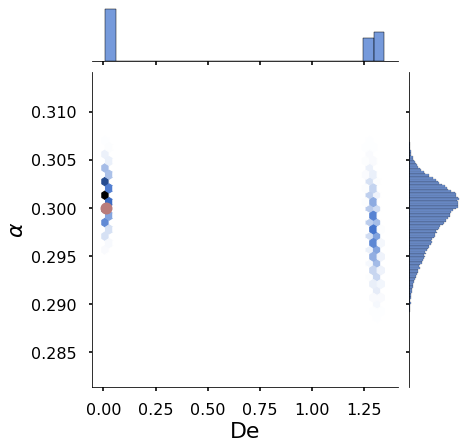

In [31]:
fig = sns.jointplot(x=sim_lar['De'], y=sim_lar['α'], kind="hex").fig
ax  = fig.axes[0]
ax.plot([0.01], [0.3], marker='o', markersize=12, color=color['mid'])
ax.set_xlabel(r'De',fontsize=22)
ax.set_ylabel(r'$\alpha$', fontsize=22)
savefig(fig, 'lar_joint')
plt.show()

In [32]:
σlar_sim, dσlar_sim = ensemble_solution(larson, dlarson, t, params['σ0'], params['κ'],
                                                   np.transpose(np.stack([sim_gie['De'][::300], sim_gie['α'][::300]])))

100%|██████████| 400/400 [00:01<00:00, 243.63it/s]


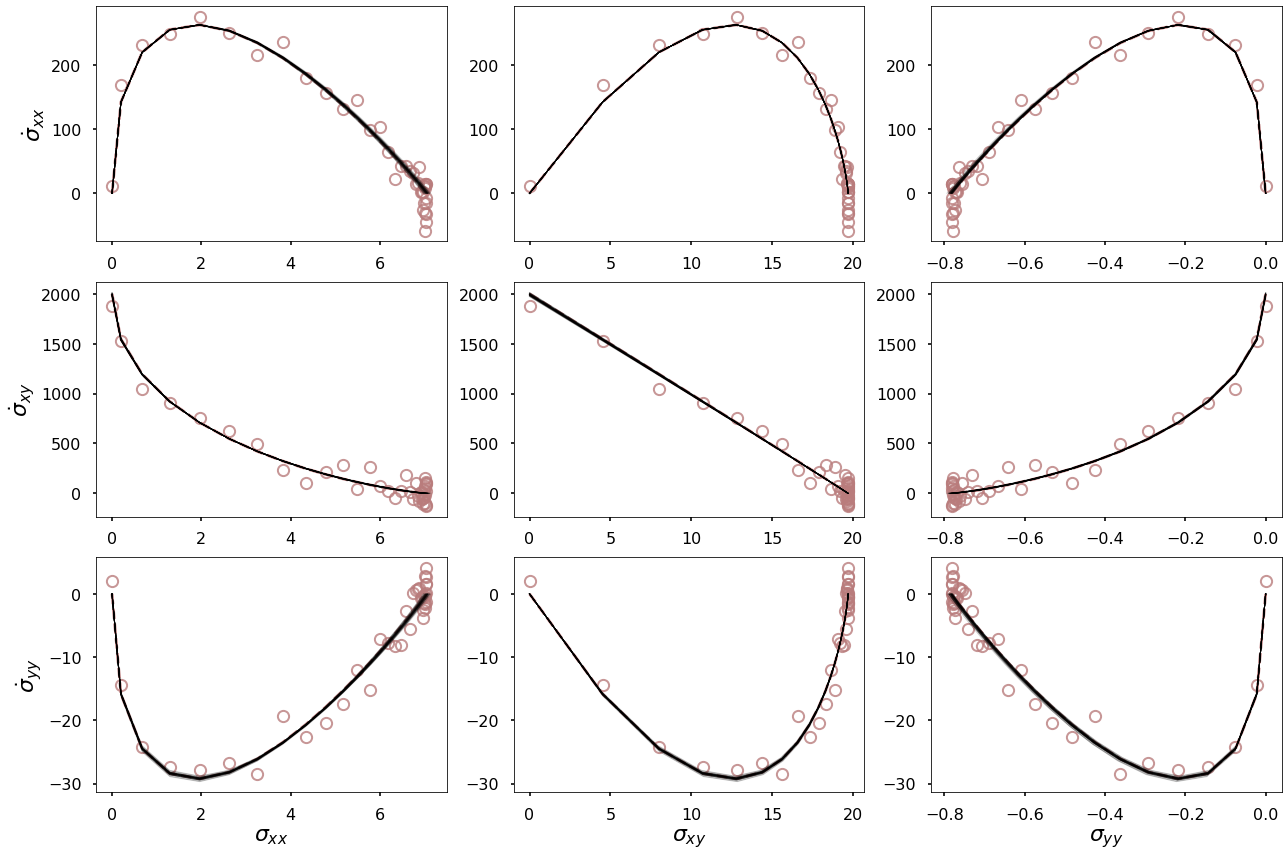

In [34]:
fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)

plot_model(axes, σlar, dσlar, dσlar_train, color=color['mid'], label='Giesekus', marker='o')
plot_posterior(axes, σlar_sim, dσlar_sim, 10, **{'alpha':0.2, 'lw':1, 'color':color['superfine']})

#axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\sigma_{lbls[i]}$", fontsize=22)

fig.tight_layout()

Let's fit the UCM and Larson data to the giesekus model

In [72]:
with model_gie:
    pm.set_data({'σ':σucm, 'σ2':dot(σucm, σucm), 'data_σdot':dσucm_train/dscale})
    sim_gie_ucm = pm.sample(20000, tune=16000, cores=6, random_seed = 123511) # draw 4000 posterior samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [logϵ, α, De]
INFO:pymc3:NUTS: [logϵ, α, De]


Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 60 seconds.
INFO:pymc3:Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 742 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 742 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7160745433818664, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameter

<Figure size 864x864 with 0 Axes>

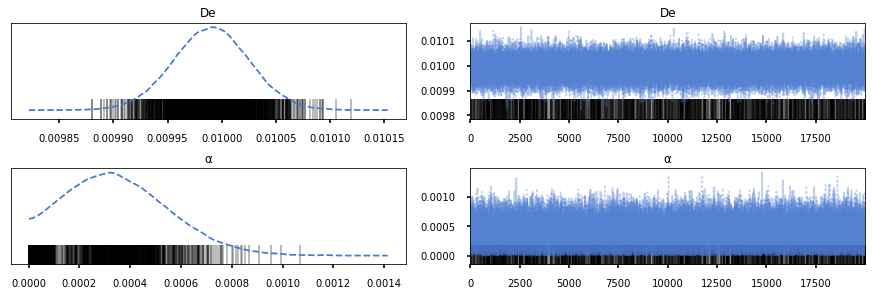

In [73]:
plt.figure(figsize=(12,12))
with model_gie:
    axes = pm.traceplot(sim_gie_ucm, var_names=['De', 'α'],combined=True)
saveaxes(axes, 'gie_ucm_trace')    
plt.show()

In [74]:
σgie_sim_ucm, dσgie_sim_ucm = ensemble_solution(giesekus, dgiesekus, t, params['σ0'], params['κ'],
                                                   np.transpose(np.stack([sim_gie_ucm['De'][::300], sim_gie_ucm['α'][::300]])))

100%|██████████| 400/400 [00:01<00:00, 379.23it/s]


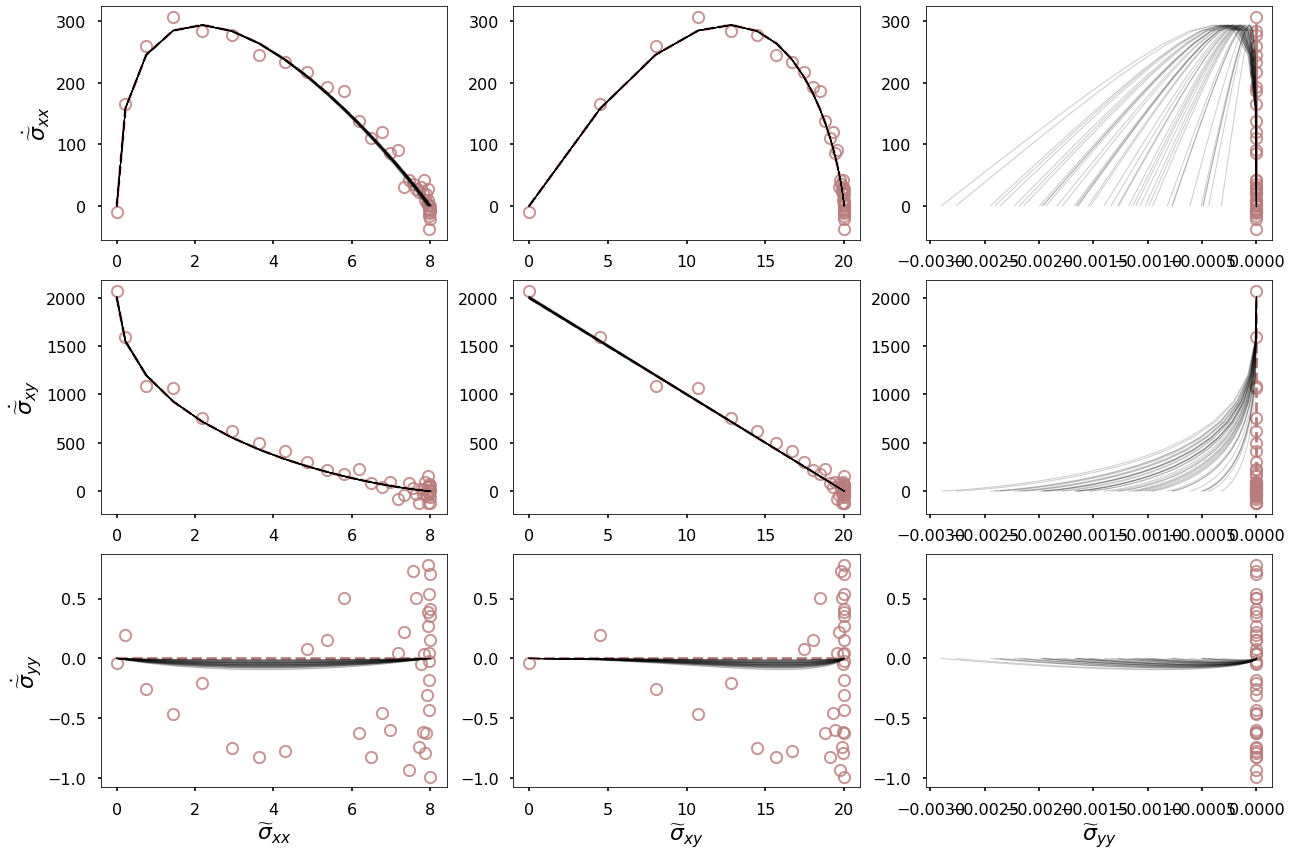

In [79]:
fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)

plot_model(axes, σucm, dσucm, dσucm_train, color=color['mid'], label='UCM', marker='o')
plot_posterior(axes, σgie_sim_ucm, dσgie_sim_ucm, 10, **{'alpha':0.2, 'lw':1, 'color':color['superfine']})

#axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\widetilde\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\widetilde\sigma_{lbls[i]}$", fontsize=22)

fig.tight_layout()

In [80]:
with model_gie:
    pm.set_data({'σ':σlar, 'σ2':dot(σlar, σlar), 'data_σdot':dσlar_train/dscale})
    sim_gie_lar = pm.sample(20000, tune=16000, cores=6, random_seed = 123511) # draw 4000 posterior samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [logϵ, α, De]
INFO:pymc3:NUTS: [logϵ, α, De]


Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 50 seconds.
INFO:pymc3:Sampling 6 chains for 16_000 tune and 20_000 draw iterations (96_000 + 120_000 draws total) took 50 seconds.


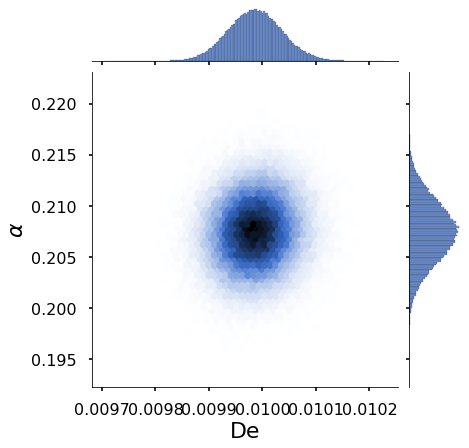

In [83]:
fig = sns.jointplot(x=sim_gie_lar['De'], y=sim_gie_lar['α'], kind="hex").fig
ax  = fig.axes[0]
ax.set_xlabel(r'De',fontsize=22)
ax.set_ylabel(r'$\alpha$', fontsize=22)
savefig(fig, 'gie_lar_joint')
plt.show()

In [85]:
σgie_sim_lar, dσgie_sim_lar = ensemble_solution(giesekus, dgiesekus, t, params['σ0'], params['κ'],
                                                   np.transpose(np.stack([sim_gie_lar['De'][::300], sim_gie_lar['α'][::300]])))

100%|██████████| 400/400 [00:01<00:00, 379.33it/s]


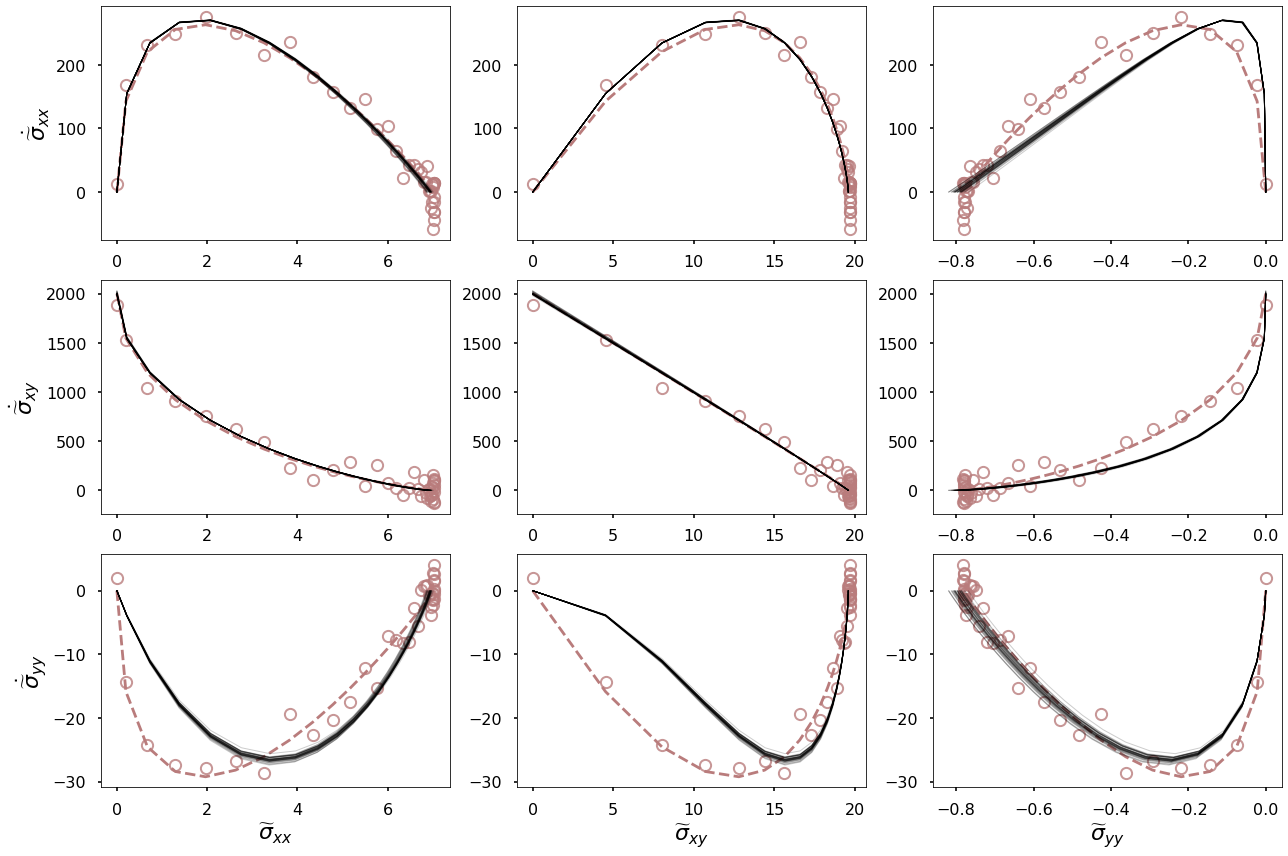

In [87]:
fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)

plot_model(axes, σlar, dσlar, dσlar_train, color=color['mid'], label='UCM', marker='o')
plot_posterior(axes, σgie_sim_lar, dσgie_sim_lar, 10, **{'alpha':0.2, 'lw':1, 'color':color['superfine']})

#axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\widetilde\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\widetilde\sigma_{lbls[i]}$", fontsize=22)

fig.tight_layout()